In [208]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [132]:
class Perceptron(object):
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):                                                                         # X : = [n_samples, n_features]
        rgen = np.random.RandomState(self.random_state)                                          # RandomeState Command ??
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.errors_ = []
        
        for _ in range(self.n_iter):
            errors = 0
        for xi, target in zip(X, y):
            update = self.eta * (target - self.predict(xi))
            self.w_[1:] += update * xi
            self.w_[0] += update
            errors += int(update != 0.0)
            self.errors_.append(errors)
        return self
    
    def net_input(self, X): 
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def predict(self, X): 
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [133]:
class AdalineGD(object):
    # w_ : 1d-array Weights after fitting. cost_ : list Sum-of-squares cost function value in each epoch.
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01,
        size=1 + X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):                                                             # Calculate net input
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):                                                            # Compute linear activation
        return X

    def predict(self, X):                                                               # Return class label after unit step
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [134]:
class AdalineSGD(object):                                                                  # ADAptive LInear NEuron classifier.
    # n_iter : int, shuffle : bool (default: True), random_state : int, w_ : 1d-array Weights, cost_ : list 
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        self.random_state = random_state

    def fit(self, X, y):
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
                cost = []
        for xi, target in zip(X, y):
            cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):                                                                               # Shuffle training data
        r = self.rgen.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):                                                   # Initialize weights to small random numbers
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01,
        size=1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):                                       # Apply Adaline learning rule to update the weights
        output = self.activation(self.net_input(xi))
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost

    def net_input(self, X):                                                                                    # Calculate net input
        return np.dot(X, self.w_[1:]) + self.w_[0]
   
    def activation(self, X):                                                                             # Compute linear activation
        return X
    
    def predict(self, X):                                                                       # Return class label after unit step
        return np.where(self.activation(self.net_input(X)) >= 0.0, 1, -1)

In [209]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
        
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
        
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, 
                    c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')

In [184]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)                                                 # extract sepal length and petal length
X = df.iloc[0:100, [0, 2]].values                                                       # X[100 x 2]

X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

In [257]:
ppn    = Perceptron(n_iter=15, eta=0.001).fit(X, y)
AdaGD1 = AdalineGD(n_iter=15, eta=0.001).fit(X, y)
AdaGD2 = AdalineGD(n_iter=15, eta=0.01).fit(X, y)
AdaSGD = AdalineSGD(n_iter=15, eta=0.001).fit(X_std, y)

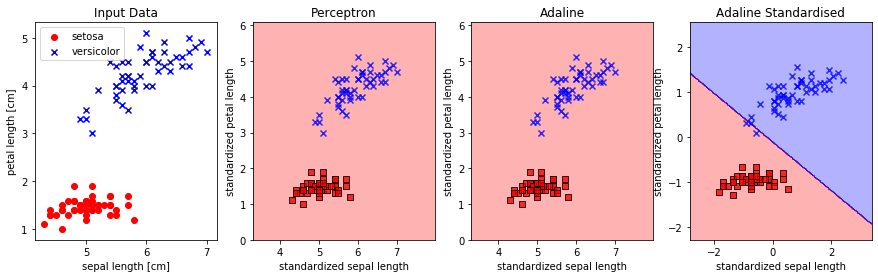

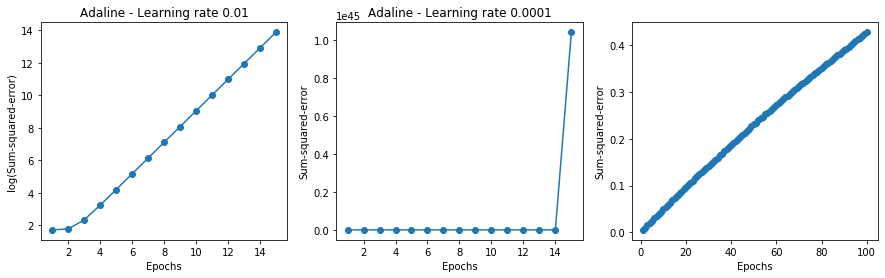

In [258]:
plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(141)
plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:100, 0], X[50:100, 1], color='blue', marker='x', label='versicolor')
plt.title('Input Data'), plt.xlabel('sepal length [cm]'), plt.ylabel('petal length [cm]'), plt.legend(loc='upper left')

plt.subplot(142)
plt.title('Perceptron'), plt.xlabel('standardized sepal length'), plt.ylabel('standardized petal length')
plot_decision_regions(X, y, classifier=ppn)

plt.subplot(143)
plt.title('Adaline'), plt.xlabel('standardized sepal length'), plt.ylabel('standardized petal length')
plot_decision_regions(X, y, classifier=AdaGD1)

plt.subplot(144)
plt.title('Adaline Standardised'), plt.xlabel('standardized sepal length'), plt.ylabel('standardized petal length')
plot_decision_regions(X_std, y, classifier=AdaSGD)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
ax[0].plot(range(1, len(AdaGD1.cost_) + 1), np.log10(AdaGD1.cost_), marker='o')
ax[0].set_xlabel('Epochs'),ax[0].set_ylabel('log(Sum-squared-error)'),ax[0].set_title('Adaline - Learning rate 0.01')

ax[1].plot(range(1, len(AdaGD2.cost_) + 1), AdaGD2.cost_, marker='o')
ax[1].set_xlabel('Epochs'), ax[1].set_ylabel('Sum-squared-error'), ax[1].set_title('Adaline - Learning rate 0.0001')

ax[2].plot(range(1, len(AdaSGD.cost_) + 1), AdaSGD.cost_, marker='o')
ax[2].set_xlabel('Epochs'), ax[2].set_ylabel('Sum-squared-error')
plt.show()